In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
# https://github.com/FutureSharks/financial-data
# pip3 install https://github.com/FutureSharks/financial-data/archive/master.zip
import pyfinancialdata # don't support pandas 2.0
import trade_functions

import os
os.environ["KERAS_BACKEND"] = "torch"

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, Activation

In [2]:
units = 25
epoch = 20
model_name = 'LSTM'

# Train on last 500 prices and try to predict the next price
look_back = 90
time_ahead = 1

# Create the model
model = Sequential()
model.add(LSTM(units, input_shape=(1, look_back)))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

/home/dev/miniconda3/envs/torch/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<Axes: title={'center': 'test data'}, xlabel='date'>

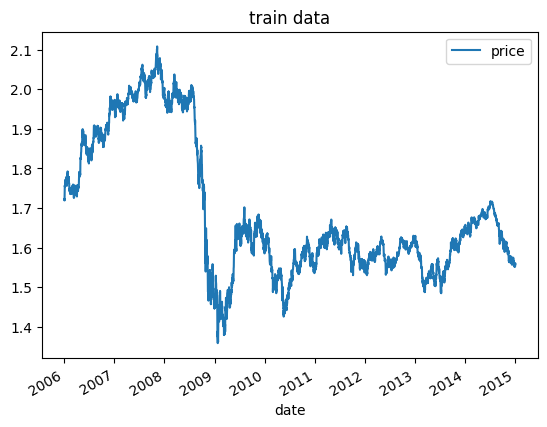

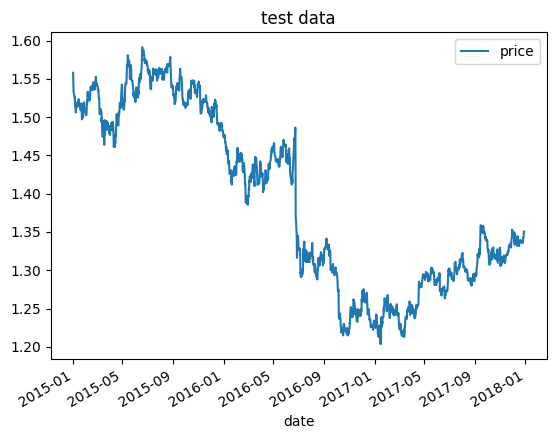

In [3]:
train_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='GBP_USD',
    years=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014],
    time_group='12h',
    price_calculation='close',
    drop_non_price_columns=True,
)

test_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='GBP_USD',
    years=[2015, 2016, 2017],
    time_group='12h',
    price_calculation='close',
    drop_non_price_columns=True,
)

train_data.plot(title='train data')
test_data.plot(title='test data')

## Train model

In [4]:
def create_training_dataset(dataset, look_back, time_ahead):
    '''
    Converts an array of values into a dataset matrix of X and Y for a sequential model
    '''
    dataX, dataY = [], []

    for i in range(len(dataset) - look_back - time_ahead + 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back + time_ahead - 1, 0])

    dataX = np.array(dataX)
    dataX = np.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1]))
    dataY = np.array(dataY)

    return dataX, dataY

In [5]:
# Create dataset from the DataFrame and normalise
dataset = train_data['price'].values
dataset = dataset.astype('float32')
dataset = dataset.reshape(-1, 1)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# Create X, Y for training
trainX, trainY = create_training_dataset(dataset, look_back=look_back, time_ahead=time_ahead)

In [6]:
model.fit(trainX, trainY, epochs=epoch, batch_size=1, verbose=1)

Epoch 1/20
 199/5208 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0140

5208/5208 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0021
Epoch 2/20
5208/5208 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 6.5707e-04
Epoch 3/20
5208/5208 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 5.9357e-04
Epoch 4/20
5208/5208 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 4.4143e-04
Epoch 5/20
5208/5208 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 4.2613e-04
Epoch 6/20
5208/5208 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 3.9005e-04
Epoch 7/20
5208/5208 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 3.7344e-04
Epoch 8/20
5208/5208 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 3.7647e-04
Epoch 9/20
5208/5208 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 3.8719e-04
Epoch 10/20
5208/5208 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 3.4966e-04
Epoch 11/20
5208/5208 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 3.4254e-04
Epoch 12/20
5208/5208 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 3.1352e-04
Epoch 13/20
5208/5208 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 2.9732e-04
Epoch 14/20
5208/5208 ━━━━━━━━━━━━━━━━━━━━ 20s 4m

## Test model

In [7]:
# Create a scaler and fit
test_scaler = MinMaxScaler(feature_range=(0, 1))
test_scaler.fit(test_data['price'].values.reshape(-1, 1))

# a function to predict
def predict(values):
    values = test_scaler.transform(values.reshape(-1, 1))
    values = np.reshape(values, (1, 1, look_back))
    prediction = model.predict(values)
    prediction = prediction.reshape(-1, 1)
    return test_scaler.inverse_transform(prediction)

In [8]:
# Put predictions from model into the dataframe with the test prices
test_data['prediction_next'] = test_data['price'].rolling(window=look_back).apply(predict, raw=True)
test_data['prediction'] = test_data['prediction_next'].shift(time_ahead)
test_data.dropna(subset=['prediction_next'], inplace=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1

In [9]:
# RMSE
rmse = np.sqrt(
    mean_squared_error(
        y_true=test_data.dropna()['price'].values,
        y_pred=test_data.dropna()['prediction'].values
    )
)
print('RMSE: {0}'.format(rmse))

RMSE: 0.008314595390161753


In [10]:
# add columns for price direction and predicted direction
test_data['next_direction'] = np.where(test_data['price'] > test_data['price'].shift(-1), -1, 1)
test_data['next_direction_prediction'] = np.where(test_data['prediction_next'] > test_data['price'], 1, -1)
test_data['correct'] = test_data['next_direction_prediction'] == test_data['next_direction']

In [11]:
# How often does the model predict the correct price change direction
test_data['correct'].value_counts()

correct
True     828
False    792
Name: count, dtype: int64

## Resources

* https://datascience.stackexchange.com/questions/76826/why-are-predictions-from-my-lstm-neural-network-lagging-behind-true-values